In [1]:
%pip install open_clip_torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import cv2
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

import open_clip
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

C:\Users\CYTech Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# create the dataset
with open('descriptions.json') as jsonfile:
    descriptions = json.load(jsonfile)

dataset = []
annotations = []
for desc in descriptions:
    description = desc['description']
    image = cv2.imread(f"images/{desc['code']}.jpg")
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    patch_height = image.shape[0] // 2

    top_img = cv2.resize(image[:patch_height], (1024, 1024))
    dataset.append((top_img, description))
    annotations.append((desc["epines"], desc["feuille_ext_acuminee"]))

    bottom_img = cv2.resize(image[patch_height:], (1024, 1024))
    dataset.append((bottom_img, description))
    annotations.append((desc["epines"], desc["feuille_ext_acuminee"]))

print(len(dataset), "images loaded")

186 images loaded


In [14]:
# split into train (80%) and test (20%)

temp = list(zip(dataset, annotations))
random.shuffle(temp)
dataset, annotations = zip(*temp)
dataset, annotations = list(dataset), list(annotations)

split = int(0.8 * len(dataset))
train_dataset = dataset[:split]
train_annotations = annotations[:split]
test_dataset = dataset[split:]
test_annotations = annotations[split:]

print(len(train_dataset), "images in train dataset")
print(len(test_dataset), "images in test dataset")

148 images in train dataset
38 images in test dataset


In [15]:
set(train_annotations)

{(False, True), (True, False), (True, True)}

Il y a moins de quatre types de plantes dans `train_dataset`. Pour que tous les exemples d'un batch soient différents, il faut donc `batch_size` $\lt 4$.

In [21]:
# create batches so that all descriptions in a given batch are different
def create_batches(dataset, annotations, batch_size=2):
    assert len(dataset) == len(annotations), "dataset and annotations must have the same length"
    batches = []
    batch = []
    current_anns = []
    unused_data = dataset.copy()
    remaining_anns = annotations.copy()
    while len(set(remaining_anns))>=batch_size:
        # pick a random index in the unused_data list
        index = random.randint(0, len(unused_data)-1)
        if remaining_anns[index] not in current_anns:
            # if the description is different from the previous ones, add the sample to the batch
            batch.append(unused_data.pop(index))
            current_anns.append(remaining_anns.pop(index))
        if len(batch) == batch_size:
            # if the batch is full, add it to the list of batches
            batches.append(batch)
            batch = []
            current_anns = []
    return batches, unused_data

batch_size = 2
batches, unused_data = create_batches(train_dataset, train_annotations, batch_size=batch_size)
print(f"{len(batches)} batches of {batch_size} images, {len(unused_data)} unused images")

25 batches of 2 images, 98 unused images


In [22]:
# check if all remaining images have the same description
unused_desc = []
for _, desc in unused_data:
    if desc not in unused_desc:
        unused_desc.append(desc)

for desc in unused_desc:
    print(desc)

A plant with thorns. Its leaves are not acuminate.


# Choix, entraînement ou fine-tuning et comparaison de deux modèles

In [6]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

# Modèle 1 : CoCa

- https://github.com/mlfoundations/open_clip
- [CoCa Colab](https://colab.research.google.com/github/mlfoundations/open_clip/blob/master/docs/Interacting_with_open_coca.ipynb)

In [37]:
model, _, preprocess  = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

tokenizer = open_clip.get_tokenizer("coca_ViT-L-14")

`model` est un objet `CoCa`


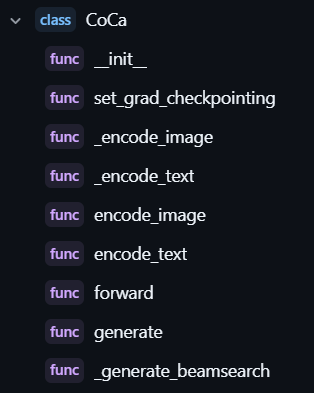

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

A plant with thorns. Its leaves are not acuminate.


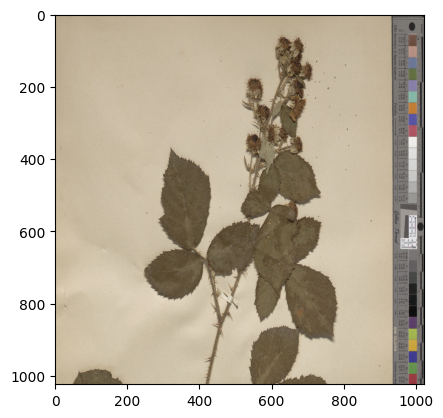

In [39]:
# take a random image
random_row = random.choice(dataset)
print(random_row[1])
plt.imshow(random_row[0])
plt.show()

In [40]:
# What can the model say about this image?

img = preprocess(Image.fromarray(random_row[0])).unsqueeze(0)

with torch.no_grad():
  generated = model.generate(img)

print(open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", ""))

a close - up of a plant with leaves on it . 


In [27]:
images, descriptions = zip(*batches[0])
print("Descriptions:", descriptions)

images = torch.stack([preprocess(Image.fromarray(img)) for img in images])
descriptions = tokenizer(descriptions)
print(f"Images shape: {images.shape}, Descriptions shape: {descriptions.shape}")

out_dict = model.forward(images, descriptions)

print("\nOutput:")
for key, value in out_dict.items():
    print(key, value.shape)

Descriptions: ('A plant with thorns. Its leaves are acuminate.', 'A plant with thorns. Its leaves are not acuminate.')
Images shape: torch.Size([2, 3, 224, 224]), Descriptions shape: torch.Size([2, 76])

Output:
image_features torch.Size([2, 768])
text_features torch.Size([2, 768])
logits torch.Size([2, 75, 49408])
logit_scale torch.Size([])
labels torch.Size([2, 75])


Cellules inspirées de [cette page](https://medium.com/aimonks/a-guide-to-fine-tuning-clip-models-with-custom-data-6c7c0d1416fb)

In [28]:
# Adam optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)

# CoCaLoss
loss = open_clip.CoCaLoss(
    caption_loss_weight=1.0,
    clip_loss_weight=1.0,
)

`loss` est un objet `CoCaLoss`

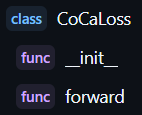 

Est-ce-que c'est une bonne idée de construire de nouveaux batchs à chaque epoch ? Pour qu'une description donnée ne puisse pas correspondre à plusieurs images au sein d'un mini-batch, on est obligé de laisser de côté certaines images. Or ces images laisées de côté lors de la construction d'un mini-batch ne sont pas les mêmes à chaque fois. Cela implique que les images observées changent d'un epoch à l'autre.

In [29]:
# train the model

model.train()

batch_size = 2
nb_epochs = 3
for epoch in range(nb_epochs):
    batches, _ = create_batches(train_dataset, train_annotations, batch_size=batch_size)
    pbar = tqdm(batches)
    for batch in pbar:
        images, texts = zip(*batch)
        images = torch.stack([preprocess(Image.fromarray(img)) for img in images])
        texts = tokenizer(texts)
        images = images.to(device)
        texts = texts.to(device)

        optimizer.zero_grad()

        # forward pass
        out_dict = model.forward(images, texts)

        # compute loss
        clip_loss, caption_loss = loss.forward(**out_dict)
        total_loss = clip_loss + caption_loss

        # backward pass
        total_loss.backward()

        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}/{nb_epochs}, Loss: {total_loss.item():.4f}")

Epoch 3/3, Loss: 0.8039: 100%|██████████| 24/24 [05:11<00:00, 12.99s/it]


In [35]:
model.eval()

with torch.no_grad():
  generated = model.generate(img)

print(open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", ""))

a plant with thorns . its leaves are not acuminate acuminate acuminate acuminate acuminate acuminate acumin
